In [1]:
### This noteboook is used for dealing with problem in ContiguousSNP
import sys
import os
import zipfile

## import function from python_scripts
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from python_scripts.gene_level_MoM import * 
from python_scripts.pairwise_product_var_calculation import * 
from python_scripts.visualization import * 
from python_scripts.weight_function import * 

In [4]:
###unzip file
zip_files = [
    "../test_data/chr1_Contiguous1KSNP.zip",
    "../test_data/chr1_Random1KSNP.zip"
]
for zf in zip_files:
    with zipfile.ZipFile(zf, "r") as z:
        z.extractall("test_data")   
    print(f"Unzipped: {zf}")
##read data  
##Random snp
RandomSNP = pd.read_csv("test_data/chr1_Random1KSNP.raw", sep=r'\s+')
RandomSNP = RandomSNP.iloc[:, 6:].to_numpy()
##Contiguous snp
ContiguousSNP = pd.read_csv("test_data/chr1_Contiguous1KSNP.raw", sep=r'\s+')
ContiguousSNP = ContiguousSNP.iloc[:, 6:].to_numpy()

Unzipped: ../test_data/chr1_Contiguous1KSNP.zip
Unzipped: ../test_data/chr1_Random1KSNP.zip


#### **Experiment 1**: Use Allel frequency of ith and jth SNP $(p_i, p_j)$ and their covariance $\sigma_{ij}$  to represent pairwise product variance (Var$ Z_i Z_j$). We will use two simulated SNPs and compare their emprical variance and variance calculatged by formula to validate.

In [5]:
# set parameter
n = 2
p1 = 0.3
p2 = 0.4
sigmaij = 0.2
c = sigmaij / n  
p11 = p1 * p2 + c
p10 = p1 - p11
p01 = p2 - p11
p00 = 1 - p11 - p10 - p01

sizes = [1000,10000,100000,1000000,10000000]

for size in sizes:
     ### simulate two SNPs
     probs = np.array([p00, p01, p10, p11])
     codes = np.random.choice(4, size=(size, n), p=probs)
     
     X1 = ((codes == 2) | (codes == 3)).sum(axis=1)
     X2 = ((codes == 1) | (codes == 3)).sum(axis=1)
     X = np.column_stack((X1, X2))
     Z = (X - X.mean(axis=0)) / X.std(axis=0)
     var_zizj_formule= calculate_varZiZj(X)[0]
     empirical_var_zizj= np.var(Z[:,0]*Z[:,1])

     ### compare their result
     print(" ")
     print(f"Under the size of individual:{size}")
     print(f"The var(zizj) given by formule:{var_zizj_formule}")
     print(f"The empirical var(zizj):{empirical_var_zizj}")
     print(f"The relative error:{(var_zizj_formule - empirical_var_zizj) / empirical_var_zizj:.6f}")

 
Under the size of individual:1000
The var(zizj) given by formule:1.0821074793449237
The empirical var(zizj):1.1048484435728123
The relative error:-0.020583
 
Under the size of individual:10000
The var(zizj) given by formule:1.0747274883315807
The empirical var(zizj):1.0840534174604655
The relative error:-0.008603
 
Under the size of individual:100000
The var(zizj) given by formule:1.0780904088916243
The empirical var(zizj):1.0781280383308671
The relative error:-0.000035
 
Under the size of individual:1000000
The var(zizj) given by formule:1.07853249628018
The empirical var(zizj):1.0774532197749014
The relative error:0.001002
 
Under the size of individual:10000000
The var(zizj) given by formule:1.0795297072917682
The empirical var(zizj):1.0795318489713448
The relative error:-0.000002


#### **Experiment 1 Summary**: As sample size increases, the formula-based variance converges to the empirical variance, with relative error dropping to ~0.01% at 10M individuals. This validates the correctness of the closed-form expression for Var$(Z_i Z_j)$

#### **Experiment 2**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by ploting the overall distribution of pairwise product variance Var$(Z_i Z_j)$.

------------------RandomSNP distribution-------------------


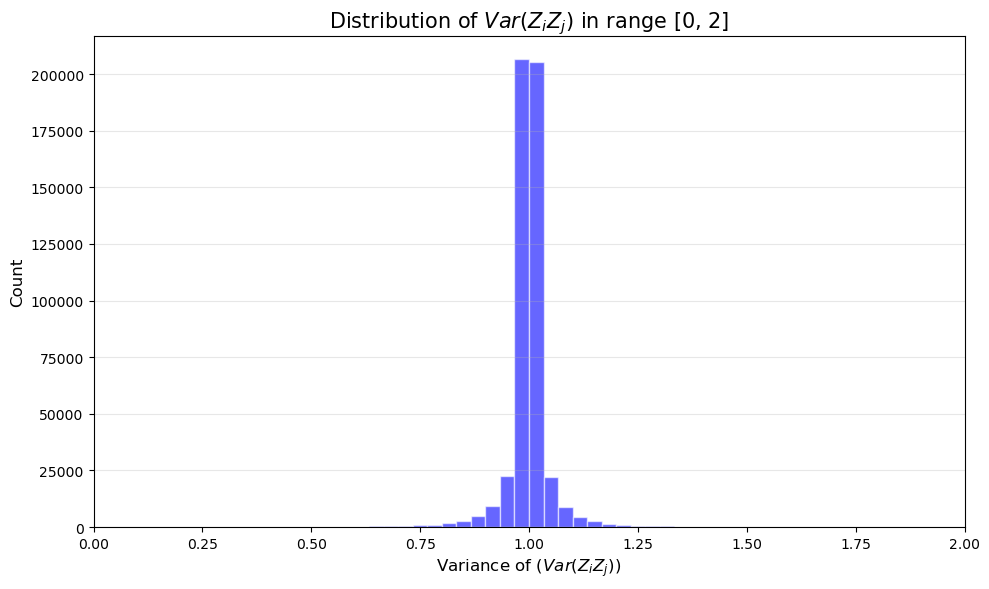

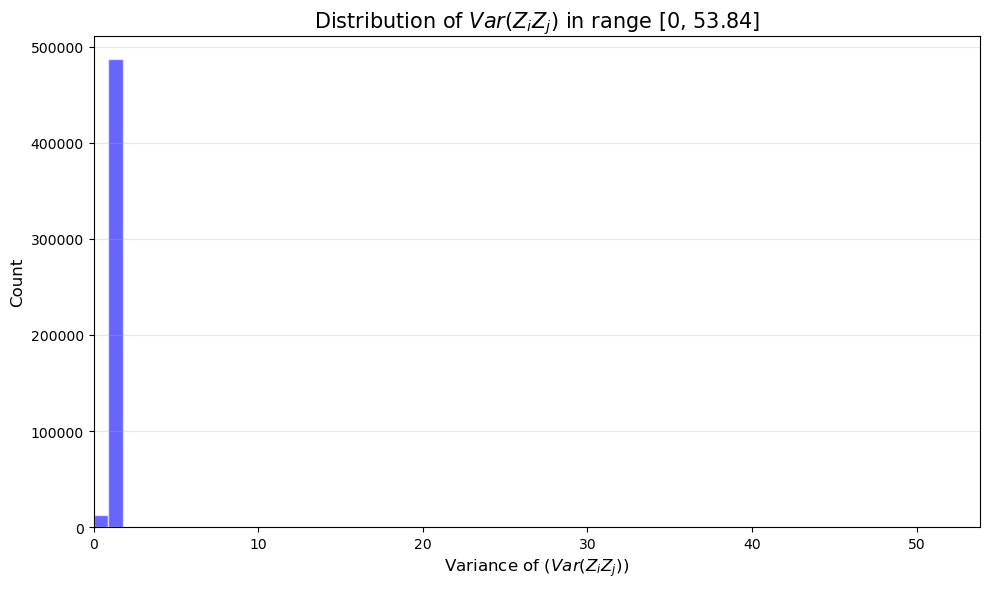

------------------ContiguousSNP distribution-------------------


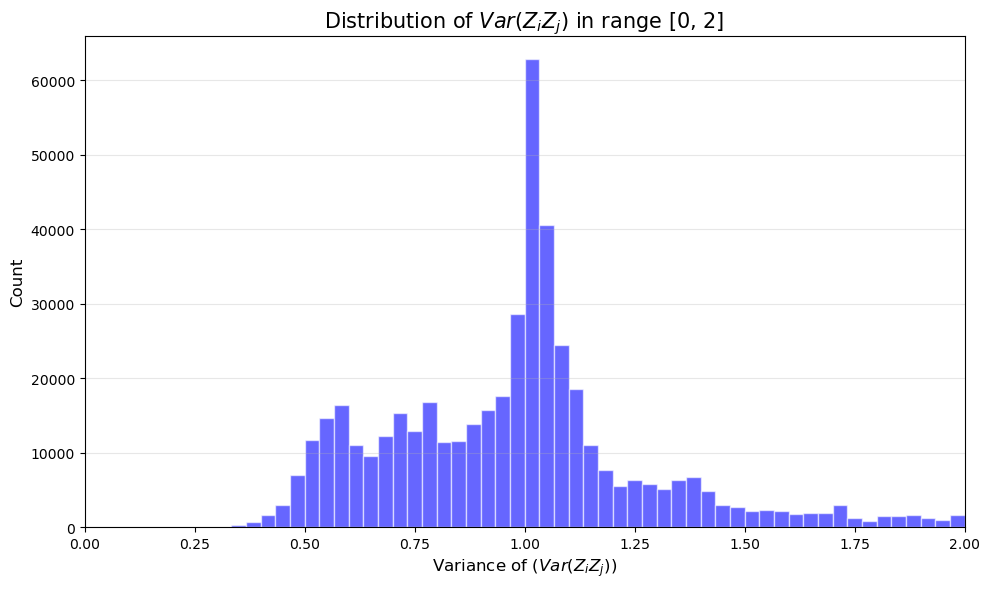

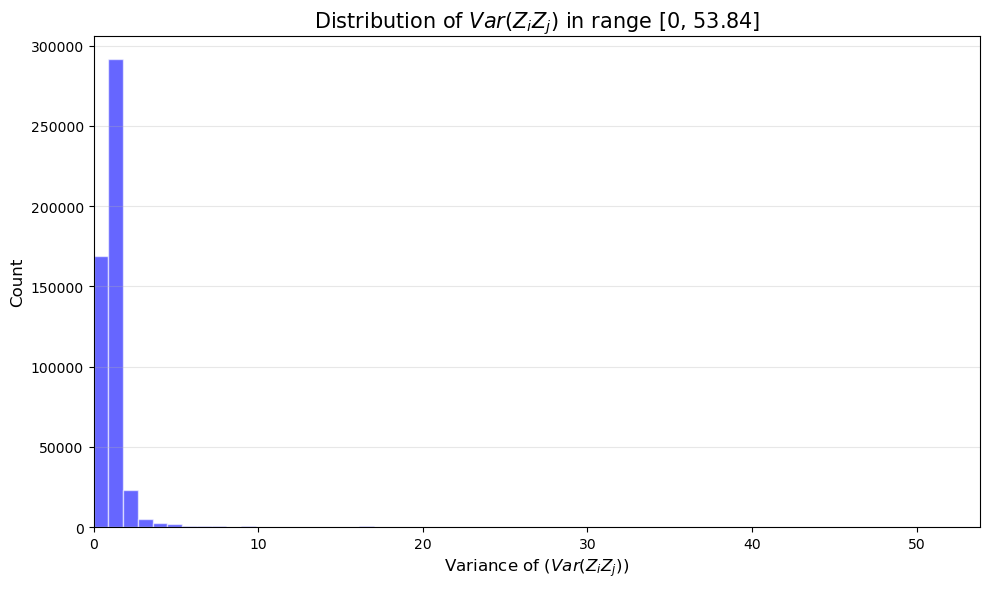

In [6]:
RandomSNP_varZiZj= calculate_varZiZj(RandomSNP)
ContiguousSNP_varZiZj= calculate_varZiZj(ContiguousSNP)

RandomSNP_varXiXj= calculate_varXiXj(RandomSNP)
ContiguousSNP_varXiXj= calculate_varXiXj(ContiguousSNP)

### draw the distribution
print("------------------RandomSNP distribution-------------------")
plot_distribution_varzizj(RandomSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(RandomSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60)  ## draw the distriburion of all variance  
print("------------------ContiguousSNP distribution-------------------")
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60) ## draw the distriburion of all variance

#### **Experiment 2 Summary**: Contiguous SNPs exhibit heavier tails with more extreme variance values compared to random SNPs, and the distribution is skewed.

#### **Experiment 3**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by examining the distribution of pairwise product variance Var$(Z_i Z_j)$ and the LD ($r_{ij}$).

------------------RandomSNP case-------------------


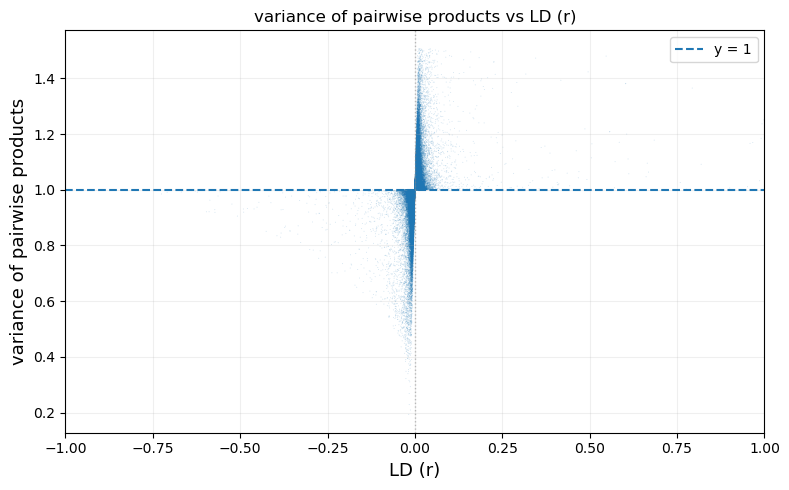

------------------ContiguousSNP case-------------------


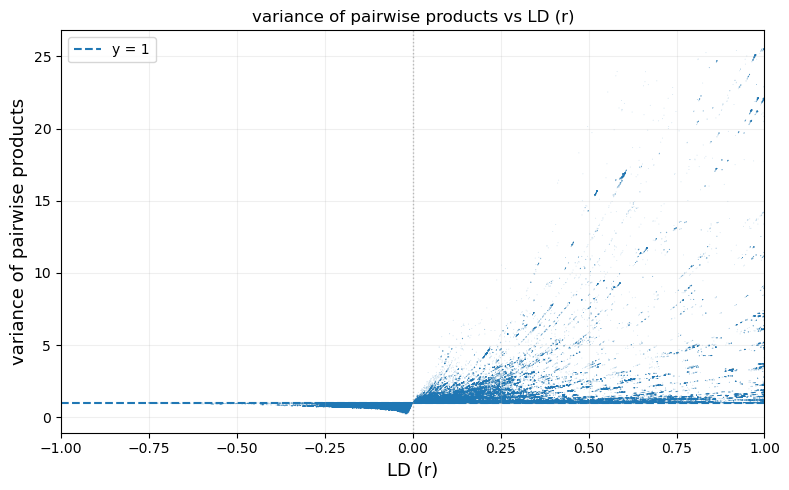

In [7]:
### experiment3: check the distibution of pairwise product variance (var zizj) against with LD (r)
def ld_vector(X):
    corr_matrix = np.corrcoef(X, rowvar=False)
    iu = np.triu_indices(X.shape[1], k=1)
    return corr_matrix[iu]


print("------------------RandomSNP case-------------------")
ld_RandomSNP =  ld_vector(RandomSNP)
plot_var_pairwise_products_against_ld(RandomSNP_varZiZj, ld_RandomSNP, q=0.999, save_path=None)


print("------------------ContiguousSNP case-------------------")
ld_ContiguousSNP =  ld_vector(ContiguousSNP)
plot_var_pairwise_products_against_ld(ContiguousSNP_varZiZj, ld_ContiguousSNP, q=0.999, save_path=None)

#### **Experiment 3 Summary**: High LD (particularly positive correlation) between Contiguous SNPs is the main factor behind inflated Var$(Z_i Z_j)$, which in turn biases the MoM estimator.

#### **Experiment 4**:

We investigate three factors that may affect gxg heritability ($h^2_{g \times g}$) estimation: linkage disequilibrium (LD), minor allele frequency (MAF), and number of SNPs. We categorize our test data into 12 groups using the following criteria:

**LD levels (3 bins):**
- High LD: SNPs pruned at $r^2 > 0.9$
- Medium LD: SNPs pruned at $r^2 > 0.5$
- Low LD: SNPs pruned at $r^2 > 0.2$

**MAF thresholds (2 bins):**
- All variants: no MAF filtering
- Common variants: MAF ≥ 0.05

**SNP number (2 bins):**
- Small dataset: ~500-600 SNPs
- Large dataset: ~1,200 SNPs

We examine how these factors influence estimation bias and standard error of $\hat h^2_{g \times g}$.

------------------Figure4.1 High LD_Large dataset_All variants case-------------------


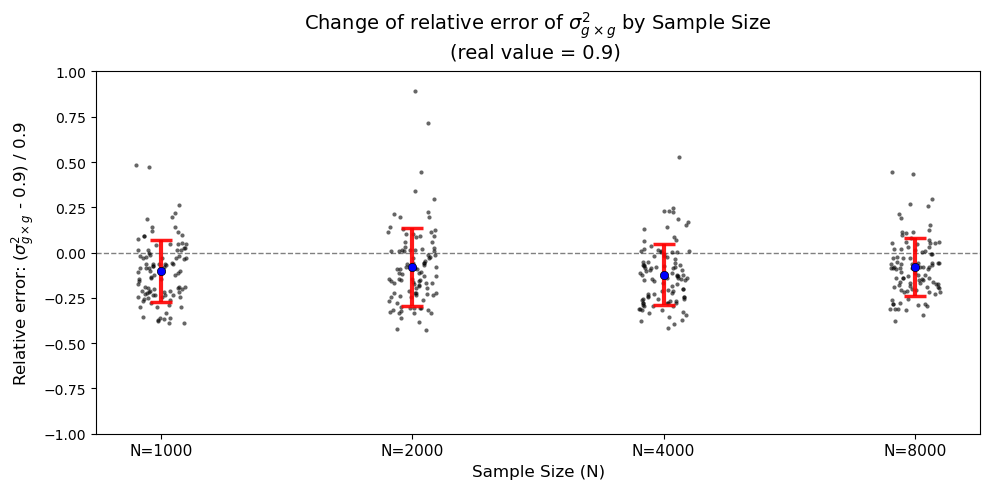

------------------Figure4.2 High LD_Large dataset_Common variants case-------------------


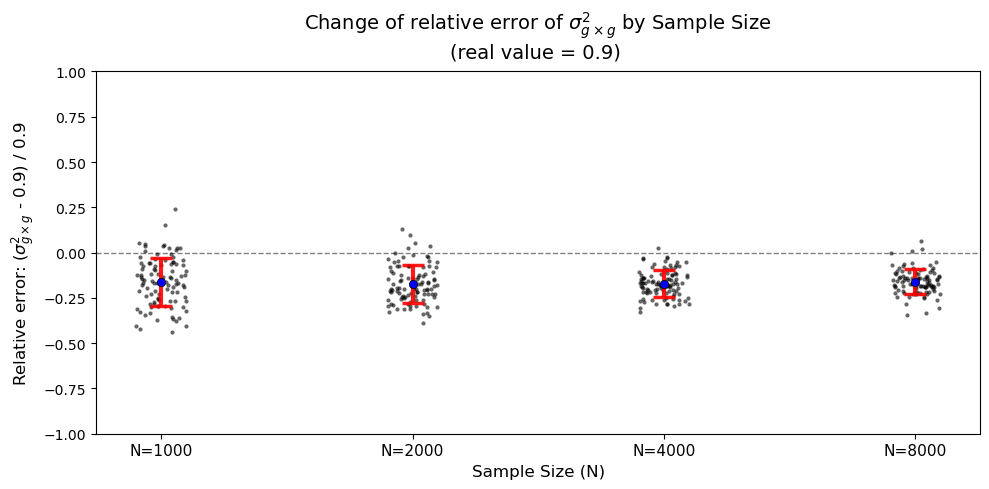

------------------Figure4.3 High LD_Small dataset_All variants case-------------------


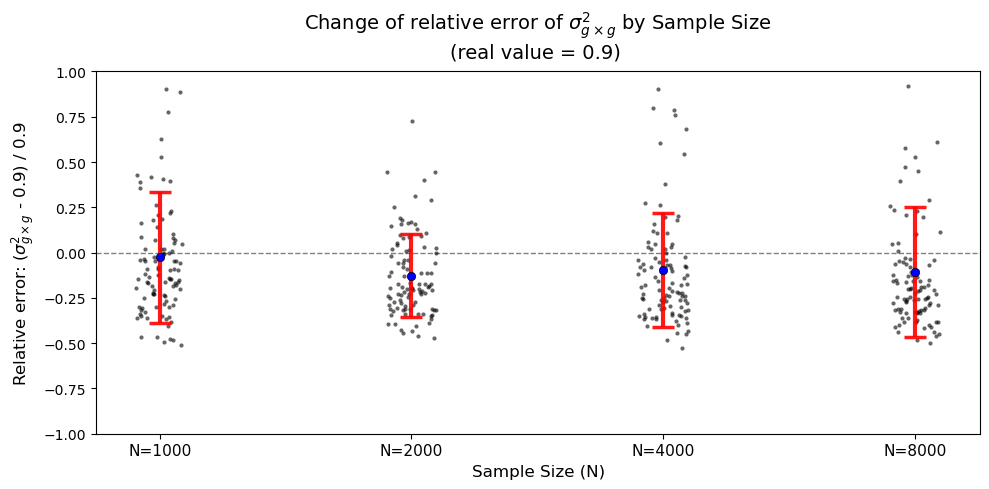

------------------Figure4.4 High LD_Small dataset_Common variants case-------------------


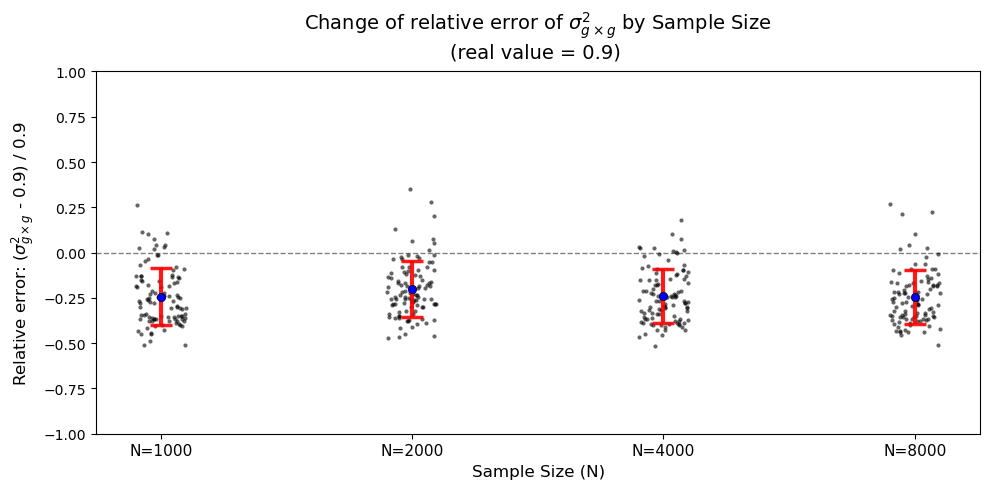

In [3]:
## highLD group

individual_sizes = [1000,2000,4000,8000]
highLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_largeDataset_allVariants/",1200)
HLA = [highLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.1 High LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *HLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


highLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_largeDataset_commonVariants/",1200)
HLC = [highLD_largeDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.2 High LD_Large dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *HLC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


highLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_smallDataset_allVariants/",592)
HSA = [highLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.3 High LD_Small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *HSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


highLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_smallDataset_commonVariants/",600)
HSC = [highLD_smallDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.4 High LD_Small dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *HSC, 
    basic_individual=1000, col_num=0, real_value=0.9, ymin=-1,ymax =1
)




------------------Figure4.5 middle LD_Large dataset_All variants case-------------------


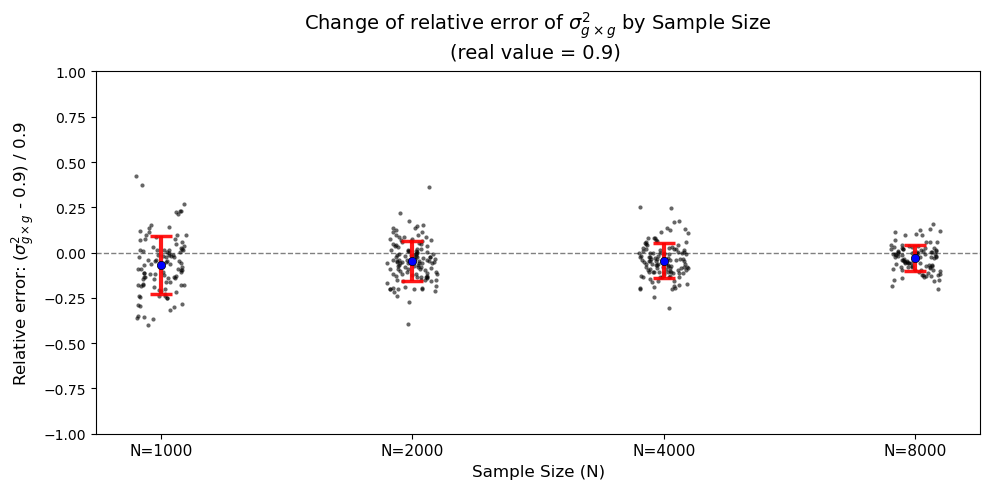

------------------Figure4.6 middle LD_Large dataset_Common variants case-------------------


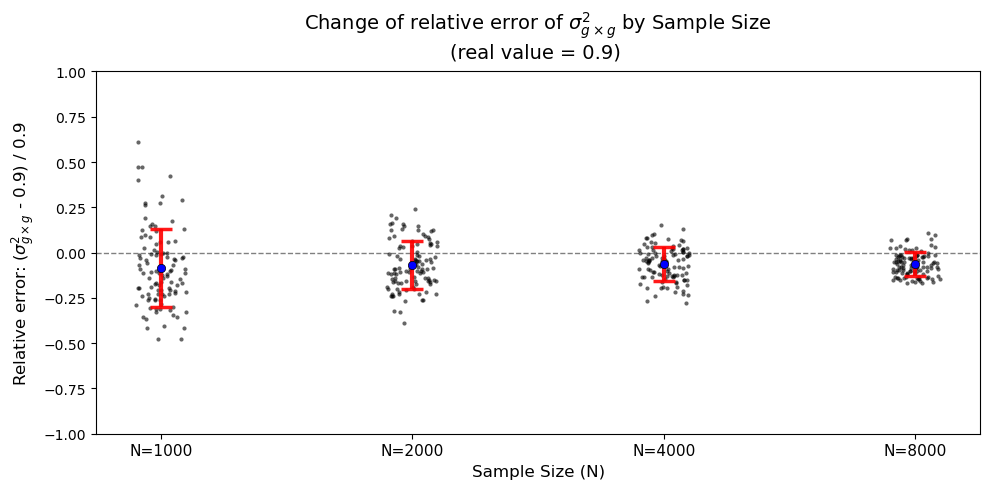

------------------Figure4.7 middle LD_small dataset_All variants case-------------------


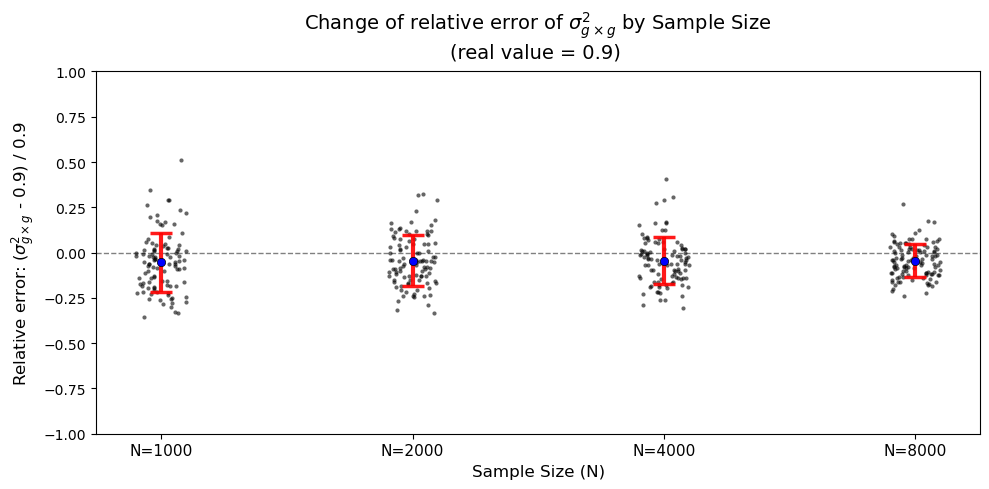

------------------Figure4.8 middle LD_small dataset_Common variants case-------------------


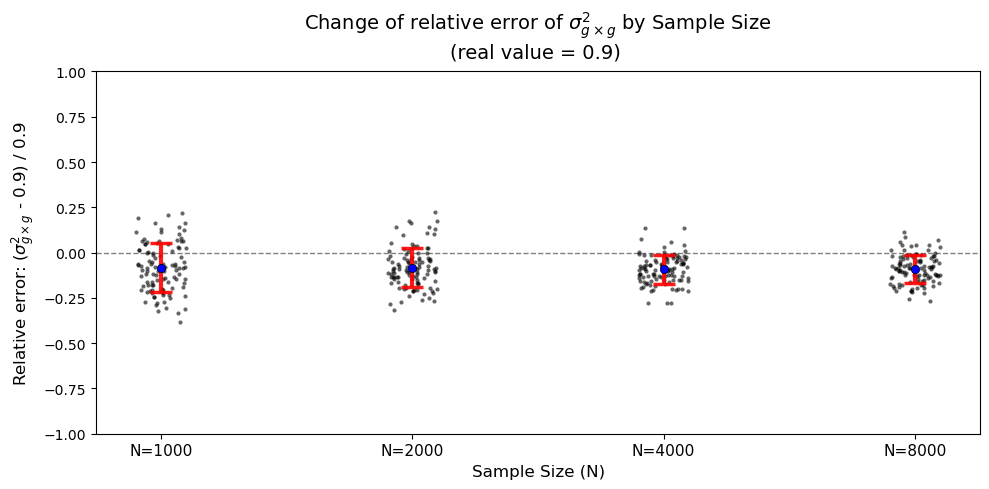

In [4]:
## middle group
individual_sizes = [1000,2000,4000,8000]
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_largeDataset_allVariants/",1200)
MLA = [middleLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.5 middle LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)

middleLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_largeDataset_commonVariants/",1200)
MLC = [middleLD_largeDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.6 middle LD_Large dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


middleLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_smallDataset_allVariants/",500)
MSA = [middleLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.7 middle LD_small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


middleLD_smallDataset_comonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_smallDataset_comonVariants/",600)
MSC = [middleLD_smallDataset_comonVariants[n] for n in individual_sizes]

print("------------------Figure4.8 middle LD_small dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *MSC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)



------------------Figure4.9 small LD_Large dataset_All variants case-------------------


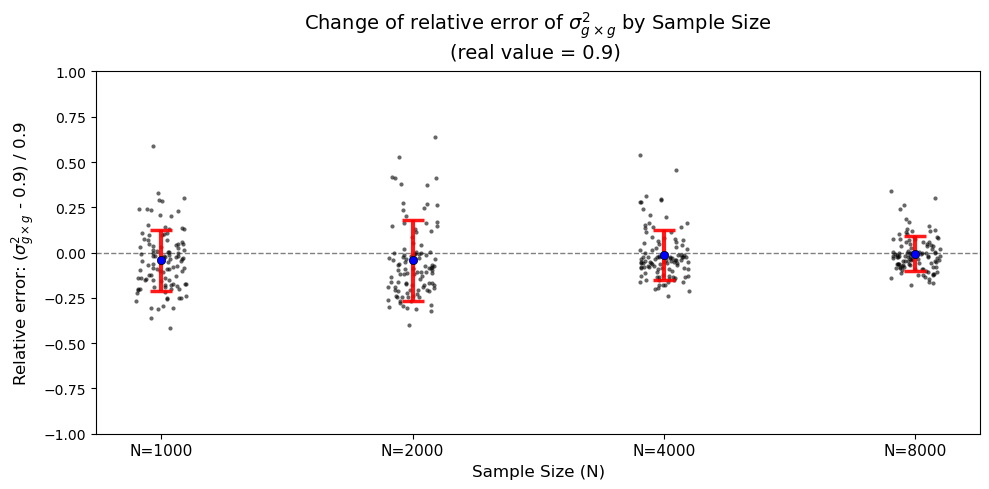

------------------Figure4.10 small LD_Large dataset_Common variants case-------------------


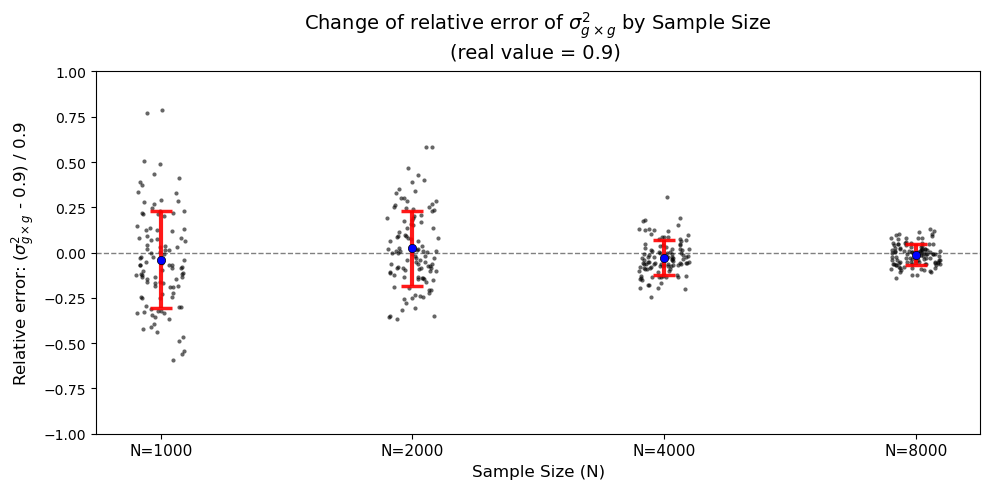

------------------Figure4.11 small LD_small dataset_All variants case-------------------


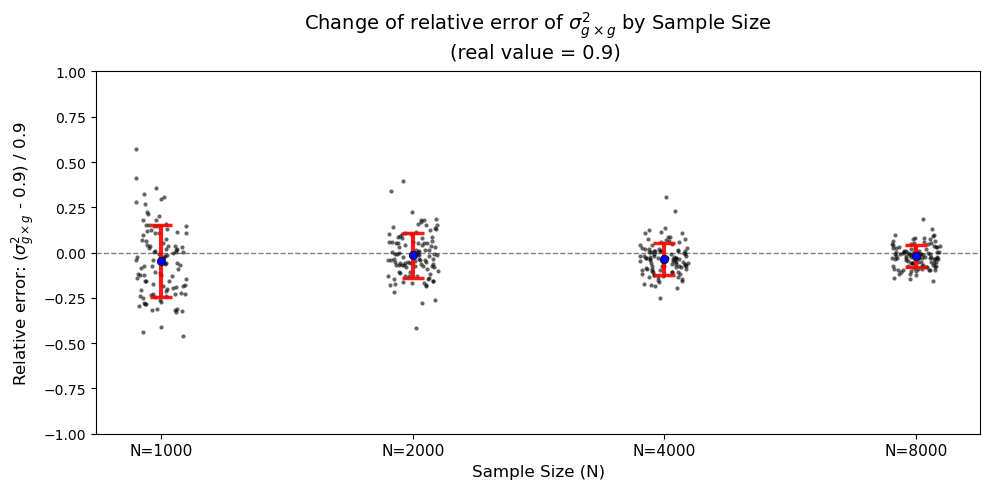

------------------Figure4.12 small LD_small dataset_Common variants case-------------------


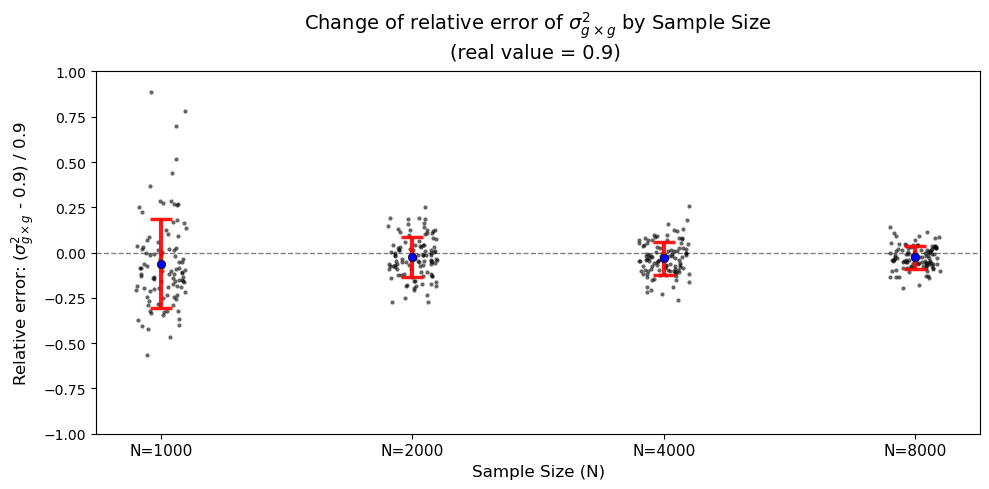

In [5]:
## low LD group
individual_sizes = [1000,2000,4000,8000]
lowLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_largeDataset_allVariants/",1200)
LLA = [lowLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.9 small LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *LLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)

lowLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_largeDataset_commonVariants/",1200)
LLC = [lowLD_largeDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.10 small LD_Large dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *LLC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


lowLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_smallDataset_allVariants/",600)
LSA = [lowLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.11 small LD_small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *LSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


lowLD_smallDataset_comonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_smallDataset_commonVariants/",524)
LSC = [lowLD_smallDataset_comonVariants[n] for n in individual_sizes]

print("------------------Figure4.12 small LD_small dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *LSC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)



#### Figure summary :
**LD**:
Based on the figures, we observe that standard error decreases with increasing sample size in the medium and low LD groups, but not in the high LD group. Both high and medium LD groups exhibit substantial bias, whereas bias is not clearly distinguishable in the low LD group. Overall, low LD outperforms medium LD, which in turn outperforms high LD for GxG estimation.

**MAF**:
Filtering out low-frequency variants shows no clear benefit for GxG estimation. In the low LD group, using all variants versus common variants produces nearly same results. However, in medium and high LD settings, MAF filtering increases bias, leading to underestimation (compare Figures 4.4 vs 4.3, 4.1 vs 4.2, and 4.7 vs 4.8).


**SNP number**:
Based on the plots, the number of SNPs does not affect bias, but its effect on standard error depends on LD level. In the low LD group, fewer SNPs yield lower standard error (Figures 4.12 vs 4.10, 4.11 vs 4.09). Conversely, in the high LD group, fewer SNPs result in higher standard error (Figures 4.4 vs 4.2, 4.3 vs 4.1).

#### **Experiment 4 Summary Part**: